### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Model
Using a <b>transfer learning</b> (InceptionV3) model from keras.

In [2]:
pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
'''
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
'''
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape : (None, 4, 4, 768)


In [4]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
#The Final layer with 3 outputs for 3 categories
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

### Preparing data for training

In [2]:
X = np.load('data/X.npy')
Y = np.load('data/Y.npy')

print(X.shape, Y.shape)

(4072, 100, 100, 3) (4072, 3)


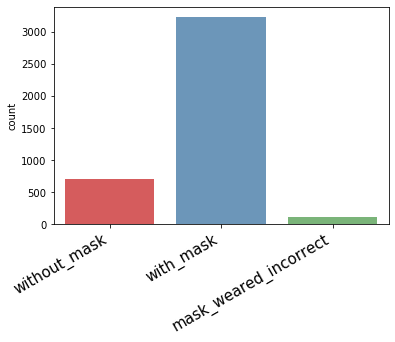

In [28]:
ax = sns.countplot(np.argmax(Y, axis=1), palette="Set1", alpha=0.8)
ax.set_xticklabels(['without_mask', 'with_mask', 'mask_weared_incorrect'], rotation=30, ha="right", fontsize=15)
plt.show()

In [8]:
# Normalizing
X = X / 255.

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

### Training

In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/model-{epoch:03d}.ckpt',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True, 
    verbose=0)

history = model.fit(X_train, 
                    Y_train, 
                    epochs=20, 
                    callbacks=[checkpoint], 
                    validation_split=0.1)

Epoch 1/20
104/104 [==============================] - 61s 589ms/step - loss: 0.5370 - acc: 0.9217 - val_loss: 0.2271 - val_acc: 0.9237
Epoch 2/20
104/104 [==============================] - 58s 560ms/step - loss: 0.1020 - acc: 0.9694 - val_loss: 0.2287 - val_acc: 0.9373
Epoch 3/20
104/104 [==============================] - 60s 575ms/step - loss: 0.0570 - acc: 0.9830 - val_loss: 0.1723 - val_acc: 0.9619
Epoch 4/20
104/104 [==============================] - 57s 549ms/step - loss: 0.0323 - acc: 0.9888 - val_loss: 0.2239 - val_acc: 0.9591
Epoch 5/20
104/104 [==============================] - 57s 547ms/step - loss: 0.0102 - acc: 0.9970 - val_loss: 0.2269 - val_acc: 0.9619
Epoch 6/20
104/104 [==============================] - 57s 546ms/step - loss: 0.0232 - acc: 0.9918 - val_loss: 0.2761 - val_acc: 0.9537
Epoch 7/20
104/104 [==============================] - 57s 547ms/step - loss: 0.0209 - acc: 0.9939 - val_loss: 0.2788 - val_acc: 0.9482
Epoch 8/20
104/104 [==============================] - 5

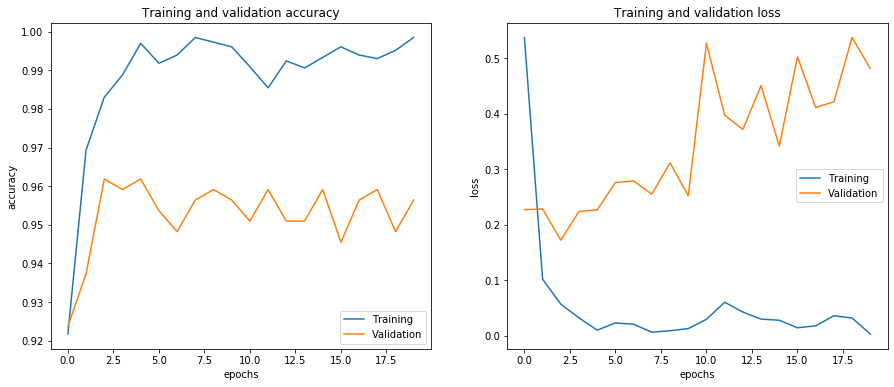

In [11]:
# PLOT LOSS AND ACCURACY
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
model.save('data/inceptionV3-model.h5')

### Testing

In [13]:
model.evaluate(X_test, Y_test)

13/13 [==============================] - 5s 413ms/step - loss: 0.3194 - acc: 0.9681


[0.31944170594215393, 0.968137264251709]

In [14]:
Y_pred = np.argmax(model.predict(X_test), axis=1)

In [15]:
Y_test = np.argmax(Y_test, axis=1)

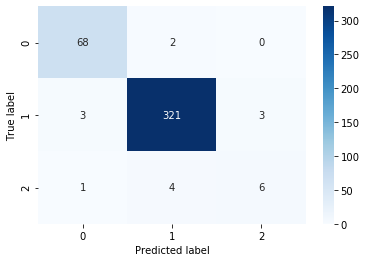

In [16]:
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()